In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files und/er the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191115_054514_1.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191004_063428.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191018_062245.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191004_063447.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191018_060715.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191114_063550.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191115_054457_2.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191018_054533.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191004_064747.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191114_062526_3.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness/Not Fresh/IMG_20191018_060409.jpg
/kaggle/input/fish-eye-freshness/Fish_Eye_Freshn

In [5]:
!pip install tensorflow
!pip install matplotlib
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from tensorflow import keras
import keras.layers
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.models import load_model
import PIL.Image as Image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import (accuracy_score,f1_score,roc_auc_score,recall_score,precision_score,confusion_matrix,roc_curve)

In [6]:
IMAGE_SIZE=224
BATCH_SIZE=32
CHANNELS=3
TRAIN_SIZE=0.80
VAL_SIZE=0.10
TEST_SIZE=0.10

In [7]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/fish-eye-freshness/Fish_Eye_Freshness",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4390 files belonging to 3 classes.


In [8]:
class_names=dataset.class_names
class_names

['Fresh', 'Highly Fresh', 'Not Fresh']

In [9]:
unbatched_dataset = dataset.unbatch()
shuffled_dataset = unbatched_dataset.shuffle(buffer_size=10000, seed=42, reshuffle_each_iteration=False)
total_size = sum(1 for _ in shuffled_dataset)
train_size = int(total_size * TRAIN_SIZE)
val_size = int(total_size * VAL_SIZE)
test_size = total_size - train_size - val_size
train_dataset = shuffled_dataset.take(train_size)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)
train_imgs = train_dataset.batch(BATCH_SIZE)
val_imgs = val_dataset.batch(BATCH_SIZE)
test_imgs = test_dataset.batch(BATCH_SIZE)
print("Number of Images in Training Dataset: {}".format(train_size))
print("Number of Images in Validation Dataset: {}".format(val_size))
print("Number of Images in Testing Dataset: {}".format(test_size))

Number of Images in Training Dataset: 3512
Number of Images in Validation Dataset: 439
Number of Images in Testing Dataset: 439


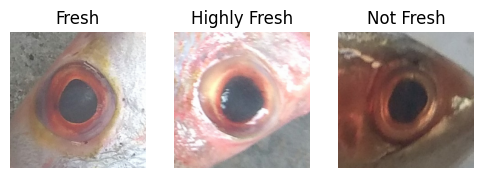

In [10]:
displayed_classes = {}
plt.figure(figsize=(6,6))

for image_batch, label_batch in dataset.take(1):
    i = 0
    for img, label in zip(image_batch, label_batch):
        class_label = label.numpy()

        if class_label not in displayed_classes:
            displayed_classes[class_label] = True
            plt.subplot(3, 3, i + 1)
            plt.imshow(img.numpy().astype("uint8"))
            plt.axis("off")
            plt.title(class_names[class_label])
            i += 1

        if i >= 3:
            break

plt.show()

In [11]:
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
base_model.trainable=False
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
callback = [
    ModelCheckpoint(filepath='model.keras', save_best_only=True, monitor='accuracy', mode='max',verbose=1),
    EarlyStopping(monitor='accuracy',mode='max', patience=7, restore_best_weights=True,verbose=1)
]
history=model.fit(train_imgs, validation_data=val_imgs, epochs=35,callbacks = callback,batch_size = BATCH_SIZE,verbose=1)
model.save('model.keras')


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/35


I0000 00:00:1733842438.463692     111 service.cc:145] XLA service 0x7f44680bb810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733842438.463747     111 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


      2/Unknown 37s 75ms/step - accuracy: 0.3125 - loss: 18.8161

I0000 00:00:1733842455.151802     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    110/Unknown 61s 224ms/step - accuracy: 0.3801 - loss: 11.3527
Epoch 1: accuracy improved from -inf to 0.42568, saving model to model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 92s 504ms/step - accuracy: 0.3806 - loss: 11.2975 - val_accuracy: 0.5125 - val_loss: 1.5500
Epoch 2/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5402 - loss: 1.4230
Epoch 2: accuracy improved from 0.42568 to 0.53787, saving model to model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 124ms/step - accuracy: 0.5401 - loss: 1.4234 - val_accuracy: 0.6196 - val_loss: 1.1391
Epoch 3/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5936 - loss: 1.0530
Epoch 3: accuracy improved from 0.53787 to 0.59994, saving model to model.keras
110/110 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - accuracy: 0.5937 - loss: 1.0527 - val_accuracy: 0.6310 - val_loss: 0.9992
Epoch 4/35
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6659 - loss: 0.8384
Epoch 4: accuracy improved from 0.59994 to 0.66458, saving model to model.k

In [12]:
all_predictions=[]
all_labels=[]
for images,labels in test_imgs:
  predictions=model.predict(images)
  predicted_classes=np.argmax(predictions,axis=1)
  all_predictions.extend(predicted_classes)
  all_labels.extend(labels.numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


In [13]:
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)
print("Confusion Matrix: ")
print(confusion_matrix(all_labels,all_predictions))

Accuracy:  0.9430523917995444
F1 Score:  0.9426866978480295
Recall:  0.9430523917995444
Precision:  0.9470005215553942
Confusion Matrix: 
[[130   3   0]
 [  3 166   0]
 [ 13   6 118]]


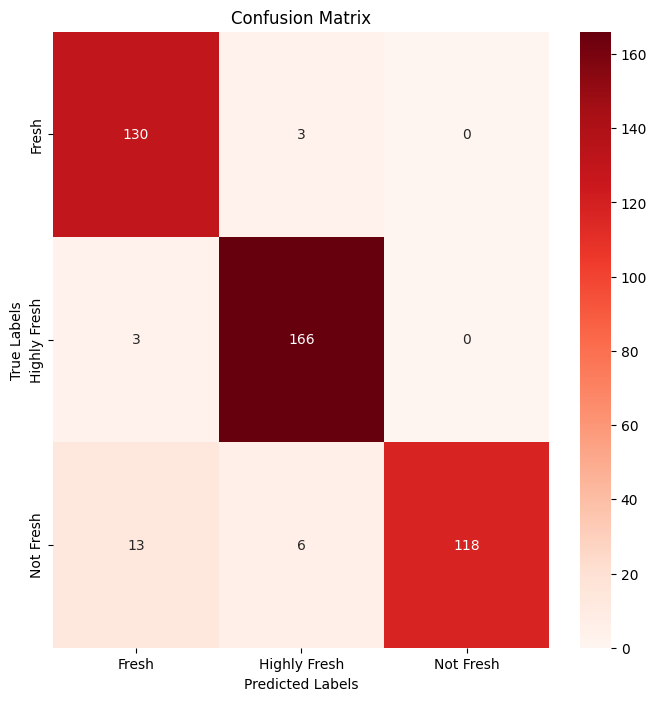

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(all_labels,all_predictions),annot=True,fmt="d",cmap="Reds",xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

Text(0.5, 1.0, 'Training and Validation Loss')

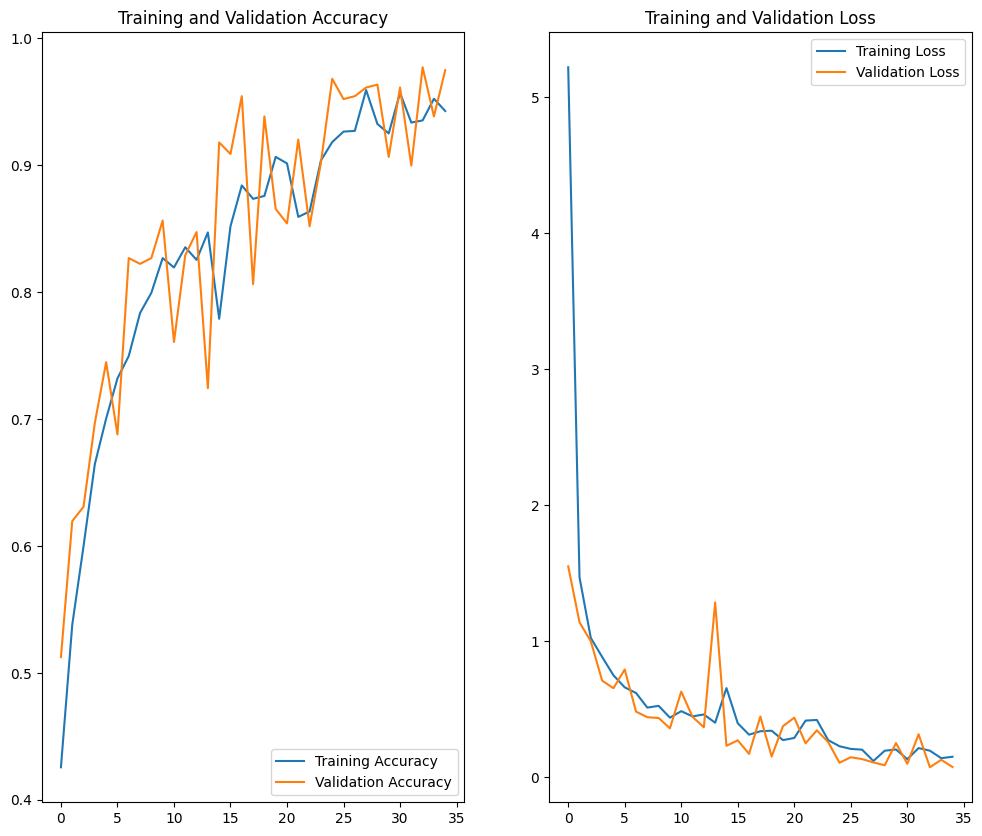

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(range(35), acc, label='Training Accuracy')
plt.plot(range(35), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(35), loss, label='Training Loss')
plt.plot(range(35), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')


In [17]:
model = load_model('model.keras')

In [18]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    try:
        predicted_class = class_names[predicted_class_index]
    except NameError:
        raise NameError("Please define `class_names` as a list of class labels before calling this function.")
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print("Predicted class:", predicted_class)

In [19]:
keras_file="model.h5"
tf.keras.models.save_model(model,keras_file)
import os
print(os.listdir('.'))

from IPython.display import FileLink
FileLink(keras_file)

['.virtual_documents', 'model.h5', 'model.keras']


/kaggle/working/model.h5